In [1]:
push!(LOAD_PATH, pwd())
using SIS,IM,PayloadGraph,PyPlot, Epidemics,JLD, TwoLevelGraphs,Dierckx
import LightGraphs

function get_c_r(N,alpha,beta)
    return 4*alpha/(beta^2*N)
end

function get_n_n(N,alpha,beta)
    return beta/alpha*N
end

function get_alpha_beta(N,c_r,n_n)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    return alpha,beta
end


f(y,alpha) = alpha.*y.^2
s(y,alpha,beta) = f(y,alpha)./y - beta
#get_y_eff(y,k) = y.*(1 + (1-y)./(y.*k))
#get_s_eff(y::Array,alpha,beta,k) = alpha*get_y_eff(y,k) - beta


function plot_schematics(N,n_n,alpha,beta,im,imk,k)
    plot_reach = true
    #pygui(true)
#     close("all")
    dx = 2*n_n/N/200
    x = collect(1/N:dx:2*n_n/N)
    if plot_reach
        y = IM.P_reach(im,N,1.0/N,x)
        yk = IM.P_reach(imk,N,1.0/N,x)
        plotfn = loglog
        plotstr = "reach"
    else
        y = IM.P_fix(im,N,x)
        yk = IM.P_fix(imk,N,x)
        plotfn = plot
        plotstr = "fix"
    end
    figure(2)#,figsize=(8,5))
    plotfn(x,y,"-r",label=latexstring("P_{$(plotstr)}(y)"))
    plotfn(x,yk,"-b",label=latexstring("P_{$(plotstr)}(y_{eff})"))
    plotfn(x,1/N./x,"--k",label=latexstring("P_{$(plotstr),neutral}"))
    xlim([1/N,2*n_n/N])
    y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)
    axvline(y_n,linestyle="--",color="b",label=L"y_n")
    axvline(y_minus,linestyle="-.",color="r",label=L"y_1")
    axvline(y_plus,linestyle="-.",color="r",label=L"y_2")
    axvline(y_p,linestyle="-",color="b",label=L"y_p")
    xlabel(L"y")
    ylabel(latexstring("P_{$(plotstr)}(y)"))
    legend(loc="best")
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))
    #savefig("p_fix_y_n = $(n_n/N), c_r = $c_r, N = $N.png")

    figure(1)#,figsize=(8,5))
    plot_schematic(n_n,c_r,N,k,true)
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))
    
    x = collect(1/N:0.01:1)
    figure(3)
    semilogx(x,get_s_eff(x,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
    semilogx(x,get_s_eff(x,alpha,beta,N-1),"-r",label=L"$s(y)$")
    grid(1)

end


function plot_schematic(n_n,c_r,N,k=N-1,plot_k=false)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
#     println(N,alpha,beta)

    y_n, y_minus,y_plus,y_p,critical_determinant = get_parameters(N,alpha,beta)
    f(y) = alpha.*y.^2
    s(y) = f(y)./y - beta
    get_y_eff(y,k) = y.*(1 + (1-y)./(y.*k))
    get_s_eff(y,alpha,beta,k) = alpha*get_y_eff(y,k) - beta


    y_range = collect(0:y_p/1000:1.9*y_p)
    plot(y_range,1.0./abs(N*s(y_range)),"-r",label=L"$\frac{1}{N|s(y)|}$")
    if plot_k
        plot(y_range,1.0./abs(N*get_s_eff(y_range,alpha,beta,k)),"-b",label=L"$\frac{1}{N|s(y_{eff})|}$")
    end
    plot(y_range,y_range,"-k",label=L"$y$")
    axvline(y_n,linestyle="--",label=L"$y_n$")
    axvline(y_p,linestyle="-",label=L"$y_p$")
    if y_minus > 0
        axvline(y_minus,linestyle="-.",label=L"$y_1$")
        axvline(y_plus,linestyle="-.",label=L"$y_2$")
    end
    ylim([0,1.9*y_p])
    legend(prop=Dict{Any,Any}("size"=>15),loc="upper right")
    xlabel(L"$y$",size=20)
    if plot_k
        #figure(1)
        #plot(y_range,get_s_eff(y_range,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
        #plot(y_range,s(y_range),"-r",label=L"$s(y)$")
        legend(prop=Dict{Any,Any}("size"=>20),loc="upper right")
        xlabel(L"$y$",size=20)
    end
end

function plot_w(sizes,N,alpha,beta,k::Int,word = "two level")

    figure(4)
    sizes = (1 + beta).*sizes
    bins = logspace(log10(minimum(sizes)),log10(maximum(sizes)),150)
#     word = graph_model ? "graph" : "well-mixed"
    label = latexstring("$word, \$k = $k\$")
    PyPlot.plt[:hist](sizes,log=true,bins=bins,alpha=0.2,normed=true,label=label)

    gca()[:set_xscale]("log")

    w_range = bins[1:end]#logspace(log10(4*minimum(sizes)),log10(maximum(sizes)),30)

    P_w_th_range = normed_distribution(w_range,P_w_th(w_range,s(sqrt(w_range)./N,alpha,beta)))
    P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,get_s_eff(sqrt(w_range)./N,alpha,beta,k)))
    #P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,
    #get_s_effective_two_level_interp(sqrt(w_range)./N,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)))
    
    correction_fac = 5
    #plot(w_range,correction_fac*P_w_th_range,"-r",label=L"theory $k \to N-1$")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    if true#graph_model
        plot(w_range,correction_fac*P_w_th_range_eff,"-b",label=latexstring("effective theory \$k = $k\$"))#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    end
        
    xlabel(L"$w$",size=20)
    ylabel(L"$P(w)$",size=20)

    legend(loc="lower left")
    ylim([1e-6,1e3])
    grid()

end
function plot_w(sizes,N,alpha,beta,s_eff_fn::Function, word = "two level")

    figure(4)
    sizes = (1 + beta).*sizes
    bins = logspace(log10(minimum(sizes)),log10(maximum(sizes)),150)
#     word = graph_model ? "graph" : "well-mixed"
    label = latexstring("$word, \$k = $k\$")
    PyPlot.plt[:hist](sizes,log=true,bins=bins,alpha=0.2,normed=true,label=label)

    gca()[:set_xscale]("log")

    w_range = bins[1:end]#logspace(log10(4*minimum(sizes)),log10(maximum(sizes)),30)

    P_w_th_range = normed_distribution(w_range,P_w_th(w_range,s(sqrt(w_range)./N,alpha,beta)))
    #P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,get_s_eff(sqrt(w_range)./N,alpha,beta,k)))
    P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,
    s_eff_fn(sqrt(w_range))./N))
    
    correction_fac = 5
    #plot(w_range,correction_fac*P_w_th_range,"-r",label=L"theory $k \to N-1$")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    if true#graph_model
        plot(w_range,correction_fac*P_w_th_range_eff,"-g",label="two-level eff. theory")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    end
        
    xlabel(L"$w$",size=20)
    ylabel(L"$P(w)$",size=20)

    legend(loc="lower left")
    ylim([1e-6,1e3])
    grid()

end

#figure out which cluster the infecteds are in from the raw data
function get_infecteds_by_clusters_vs_time(clusters::Array{Array{Int,1},1},infecteds_by_nodes_vs_time::Array{Array{Int,1},1})
    infecteds_by_clusters_vs_time::Array{Array{Int,1},1} = []
    num_clusters = length(clusters)
    for infecteds_by_nodes in infecteds_by_nodes_vs_time
        infecteds_by_clusters = zeros(Int,num_clusters)
        for (i,clust) in enumerate(clusters)
            for node in clust
                if infecteds_by_nodes[node] == 1
                    infecteds_by_clusters[i] += 1
                end
            end
        end
        push!(infecteds_by_clusters_vs_time,infecteds_by_clusters)
    end
    return infecteds_by_clusters_vs_time
    
end

#we have infecteds vs. cluster idx and want to know how many clusters of infectivity level i there are for every possible i=1:m
function get_infection_distribution_over_clusters(t::TwoLevel,infecteds_by_clusters)
    assert(t.n == length(infecteds_by_clusters))
    infection_distribution = zeros(Int,t.m+1)
    for (i,num_infected) in enumerate(infecteds_by_clusters)
        infection_distribution[num_infected+1] += 1
    end
    return infection_distribution
end

function get_two_level_with_distribution(t_template::TwoLevel,infection_distribution::Array{Int,1})
    assert(t_template.m + 1 == length(infection_distribution))
    t = TwoLevel(t_template)
    t.a = infection_distribution
    make_consistent(t)
    return t
end

function get_two_level_states(tg::TwoLevelGraph,infecteds_by_nodes_vs_time::Array{Array{Int,1},1})
    two_level_states::Array{TwoLevel,1} = []
    infecteds_by_clusters_vs_time = get_infecteds_by_clusters_vs_time(tg.clusters,infecteds_by_nodes_vs_time)
    for infecteds_by_clusters in infecteds_by_clusters_vs_time
        push!(two_level_states,get_two_level_with_distribution(tg.t,get_infection_distribution_over_clusters(tg.t,infecteds_by_clusters)))
    end
    return two_level_states
end

function get_two_level_states_from_runs(runs::Array{EpidemicRun,1})
    tg_raw = runs[1].graph_information.data
    t_raw = runs[1].graph_information.data.t
    t::TwoLevel = TwoLevel(t_raw.a,t_raw.N,t_raw.m,t_raw.n,t_raw.i,t_raw.r,t_raw.l)
    tg::TwoLevelGraph = TwoLevelGraph(tg_raw.g,t,tg_raw.clusters)
    two_level_states::Array{TwoLevel,1} = []
    for run in runs
        two_level_states = vcat(two_level_states,get_two_level_states(tg,run.infecteds_by_nodes_vs_time))
    end
    return two_level_states
end

function get_mean_distribution_from_states(two_level_states::Array{TwoLevel,1},y_desired::AbstractFloat,tol= 0.005)
    counter = 0
    t = two_level_states[1]
    accum = zeros(length(t.a))
    for t in two_level_states
        if y_desired-tolerance< t.i/t.N < y_desired+tolerance
            counter += 1
            accum += t.a
        end
    end
    accum /= counter
    println("$counter instances")
    return accum
end


get_mean_distribution_from_states (generic function with 2 methods)

In [2]:
# s(x) = get_s_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
# splus(x) = get_splus_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)

# s1(x) = alpha*x - beta
# splus1(x) = 2 + beta + alpha*x


# s2(x) = p_birth(im_effective,x) - p_death(im_effective,x)
# splus2(x) =  p_birth(im_effective,x) + p_death(im_effective,x)

# max_evals = 100

# function P_fix(s::Function,splus::Function,N::Int,x0::Real)
#     eps = 1e-5
#     a(x) = s(x)
#     b(x) = 1/N*(splus(x))
    
#     psi(x,a,b) = exp( -2* quadgk(y -> a(y)/b(y),eps,x,maxevals=max_evals)[1])
    
#     return quadgk(y -> psi(y,a,b),eps,x0,maxevals=max_evals)[1]/quadgk(y -> psi(y,a,b),eps,1,maxevals=max_evals)[1]
# end
# import IM.P_reach
# function P_reach(s::Function,splus::Function,N::Int,x0::Real,x1::Real)
#     eps = 1e-5
#     a(x) = s(x)
#     b(x) = 1/N*(splus(x))
    
#     psi(x,a,b) = exp( -2* quadgk(y -> a(y)/b(y),eps,x,maxevals=max_evals)[1])
    
#     return quadgk(y -> psi(y,a,b),eps,x0,maxevals=max_evals)[1]/quadgk(y -> psi(y,a,b),eps,x1,maxevals=max_evals)[1]
# end

# function P_reach(s::Function,splus::Function,N::Int,x0::Real,x1::Array)
#     return [P_reach(s,splus,N,x0,xind) for xind in x1]
# end

# function P_reach(im::InfectionModel,N::Int,x0::Real,x1::Real)
#     eps = 1e-6
#     s(x) = (1-x)*(p_birth(im,x) - p_death(im,x))
#     a(x) = x*s(x)
#     b(x) = 1/N*(1-x)*x*(p_birth(im,x) + p_death(im,x))
    
#     psi(x,a,b) = exp( -2* quadgk(y -> a(y)/b(y),0,x,maxevals=max_evals)[1])
    
#     return quadgk(y -> psi(y,a,b),eps,x0,maxevals=max_evals)[1]/quadgk(y -> psi(y,a,b),eps,x1,maxevals=max_evals)[1]
# end

# function P_reach(im::InfectionModel,N::Int,x0::Real,x1::Array)
#     return [P_reach(im,N,x0,xind) for xind in x1]
# end

# using Dierckx
# function P_reach_fast(s::Function,splus::Function,N::Int,x0::Real,x1::Real)
#     eps = 1e-5
#     a(x) = s(x)
#     b(x) = 1/N*(splus(x))
    
#     psi(x,a,b) = exp( -2* quadgk(y -> a(y)/b(y),eps,x,maxevals=max_evals)[1])
#     xx = logspace(log10(1/N)-1,0,1000)
#     yy = zeros(xx)
#     for i in 1:length(xx)
#         yy[i] = psi(xx[i],a,b)
#     end
#     psi_spline = Spline1D(xx,yy,k=1,bc="extrapolate")
#     psi_interp(x) = evaluate(psi_spline,x)
    
#     return quadgk(y -> psi_interp(y),eps,x0,maxevals=max_evals)[1]/quadgk(y -> psi_interp(y),eps,x1,maxevals=max_evals)[1]
# end

# function P_reach_fast(s::Function,splus::Function,N::Int,x0::Real,x1::Array)
#     return [P_reach_fast(s,splus,N,x0,xind) for xind in x1]
# end
# # a(x) = x.*s(x)
# # b(x) = 1.0/N*(1-x).*x.*splus(x)

# a_over_b(x) = N*s(x)./splus(x)
# psi(x,a_over_b) = exp( -2* quadgk(y -> a_over_b(y),0,x)[1])


function plot_two_level_schematic(t,alpha,beta,N)
    y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
    println("computed interpolations")

    s(x) = get_s_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
    splus(x) = get_splus_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)

    xx = logspace(log10(1/N),0,20) 
    pp = IM.P_reach_fast(s,splus,N,1/N,xx)
#     loglog(xx,pp)
#     xlim([1/N,1])
    return xx,pp,s
end




plot_two_level_schematic (generic function with 1 method)

In [9]:
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"


"../data/"

In [10]:
filenames = split(readall(`ls $data_dir_path`));
filenames

11-element Array{SubString{ASCIIString},1}:
 "epidemics_graph_2016-09-15T23:19:28.jld"
 "epidemics_graph_2016-09-15T23:25:11.jld"
 "epidemics_graph_2016-09-15T23:27:30.jld"
 "epidemics_graph_2016-09-15T23:34:07.jld"
 "epidemics_graph_2016-09-16T01:02:54.jld"
 "epidemics_graph_2016-09-16T01:06:51.jld"
 "epidemics_graph_2016-09-16T01:07:55.jld"
 "epidemics_graph_2016-09-16T01:11:52.jld"
 "epidemics_graph_2016-09-16T01:50:48.jld"
 "epidemics_graph_2016-09-16T02:00:44.jld"
 "interpolations.jld"                     

In [41]:
d = load(data_dir_path*filenames[4])

TWO_LEVEL = 3
REGULAR = 2
RANDOM = 1

params = d["params"]
runs = d["runs"];
num_fixed = get_num_fixed(runs) #d["num_fixed"]
sizes = get_sizes(runs) #d["sizes"]
N = params["N"]
xvals,pvals = get_p_reach(runs,N)




alpha = params["alpha"]
beta = params["beta"]
k = params["k"]
num_trials = length(runs)
graph_model = params["graph_model"]
graph_type = params["graph_type"]

println("Graph Type: $(graph_type)")


c_r = get_c_r(N,alpha,beta)
n_n = get_n_n(N,alpha,beta)

if graph_type == TWO_LEVEL
    t = runs[1].graph_information.data.t
    k = t.l + t.r
end
println("k = $k")

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)

#plot_schematics(N,alpha,beta,k,true)



#plot_w(sizes,N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);

println(num_fixed/num_trials," ", IM.P_fix(imk,N,1/N))

println("Is graph: $graph_model")



Graph Type: 2
k = 12
0.0003 0.0007352593671366466
Is graph: true


In [39]:
k,n_n,c_r,N,l,r,t

(4,80.0,0.17999999999999997,400,10,2,TwoLevelGraphs.TwoLevel(Number[0,0,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0],400,20,20,0,2,10))

In [37]:
xvals_two_level_g,pvals_two_level_g = xvals,pvals

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.09,0.0925,0.0975,0.1025,0.105,0.1125,0.115,0.1175,0.1225,1.0],[1.0,0.4579,0.2845,0.2101,0.1633,0.1355,0.115,0.1004,0.0901,0.0823  …  0.0422,0.0419,0.0417,0.0416,0.0411,0.041,0.0406,0.0405,0.0404,0.0403])

In [206]:
# xvals_two_level_g1,pvals_two_level_g1 = xvals,pvals
# xvals_two_level_g2,pvals_two_level_g2 = xvals,pvals
# xvals_regular4_g,pvals_regular4_g = xvals,pvals

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.09,0.0925,0.0975,0.1025,0.105,0.1125,0.115,0.1175,0.1225,1.0],[1.0,0.4579,0.2845,0.2101,0.1633,0.1355,0.115,0.1004,0.0901,0.0823  …  0.0422,0.0419,0.0417,0.0416,0.0411,0.041,0.0406,0.0405,0.0404,0.0403])

In [42]:

xvals_regular12_g,pvals_regular12_g = xvals,pvals

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.11,0.1125,0.115,0.1325,0.1425,0.1475,0.1625,0.1875,0.195,1.0],[1.0,0.459,0.2833,0.1976,0.1498,0.1153,0.0913,0.0729,0.0607,0.0514  …  0.0013,0.0012,0.0011,0.001,0.0009,0.0008,0.0007,0.0006,0.0005,0.0003])

In [10]:
xvals_mixed_g,pvals_mixed_g = xvals,pvals

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025,1.0],[1.0,0.5748,0.4569,0.4129,0.3946,0.3872,0.3848,0.3837,0.383,0.3828,0.3827])

In [3]:
k = 12
#y_n = 0.1
c_r = 0.8 #0.18
N = 400#100000#400
n_n = 100#10#80#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
println("N=$N, alpha = $alpha, beta = $beta")

#Generate a random startin vector
m = 20#20 number of nodes in a community
n = Int(N/m) 
l = 10#Int(m/2)#10#internal
r = 2#2#Int(m/2)#2 #external

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);


y_desired = 0.003

t = TwoLevel(N,m,l,r)
#distribute_randomly(t,n)
adjust_infecteds(t,y_desired)
make_consistent(t)
assert(is_valid(t))
println(t.i/t.N)

N=400, alpha = 0.2, beta = 0.05
0.0025


In [4]:
xx,yy,s_eff_two_level = plot_two_level_schematic(t,alpha,beta,N)

Lower: 1.5199110829529339 upper: 2.0092330025650473. Mid: 1.7645720427589906
f_out(x_mid): (0.001160206535931186,true)
success: 100/100
14 binary search iterations.
Lower: 1.5199110829529339 upper: 2.0092330025650473. Mid: 1.7645720427589906
f_out(x_mid): (0.0012410984643468827,true)
success: 100/100
14 binary search iterations.
Lower: 1.5199110829529339 upper: 2.0092330025650473. Mid: 1.7645720427589906
f_out(x_mid): (0.0013276201692706735,true)
success: 100/100
14 binary search iterations.
Lower: 1.5199110829529339 upper: 2.0092330025650473. Mid: 1.7645720427589906
f_out(x_mid): (0.0014201619948612345,true)
success: 100/100
14 binary search iterations.
Lower: 1.5199110829529339 upper: 2.0092330025650473. Mid: 1.7645720427589906
f_out(x_mid): (0.0015191411384229215,true)
success: 100/100
14 binary search iterations.
Lower: 1.5199110829529339 upper: 2.0092330025650473. Mid: 1.7645720427589906
f_out(x_mid): (0.0016250034671912792,true)
success: 100/100
14 binary search iterations.
Lower

([0.002499999999999999,0.0034268140159417954,0.004697221719942055,0.006438602090353466,0.008825556754518162,0.012097416633949058,0.01658223875116162,0.022729699267269535,0.031156180810888504,0.04270657483438782,0.058538995686138955,0.08024090035856693,0.10998825680021053,0.1507637199967868,0.20665569151220545,0.28326824805926787,0.38828304108831074,0.5322295069415711,0.7295406136340671,1.0],Any[1.0000000000000004,0.731444834425452,0.5359090439904258,0.3934748884190547,0.28969551643143787,0.2140776319128285,0.15899303669473788,0.11889456599310638,0.08975007551263696,0.06863302952695782,0.0534267422564325,0.04261134773228189,0.03510858032046018,0.030162965180063013,0.027230760584058572,0.025832784659631347,0.02540169223429199,0.025342444409238607,0.02534185749070916,0.025341602510972925],s)

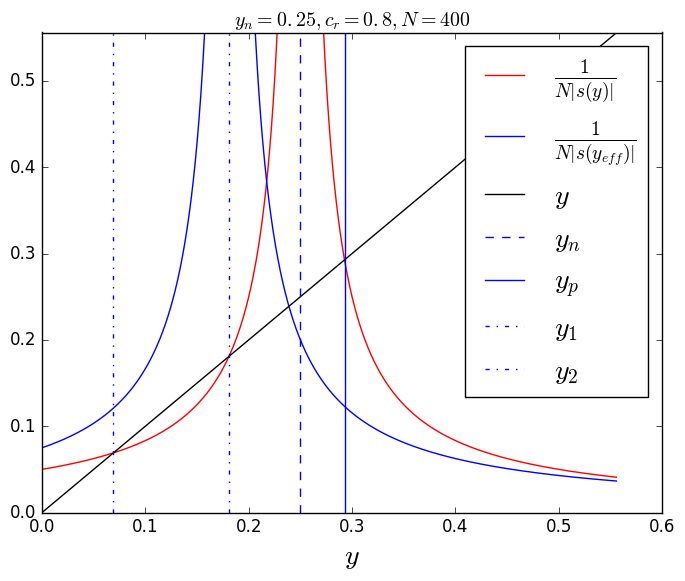

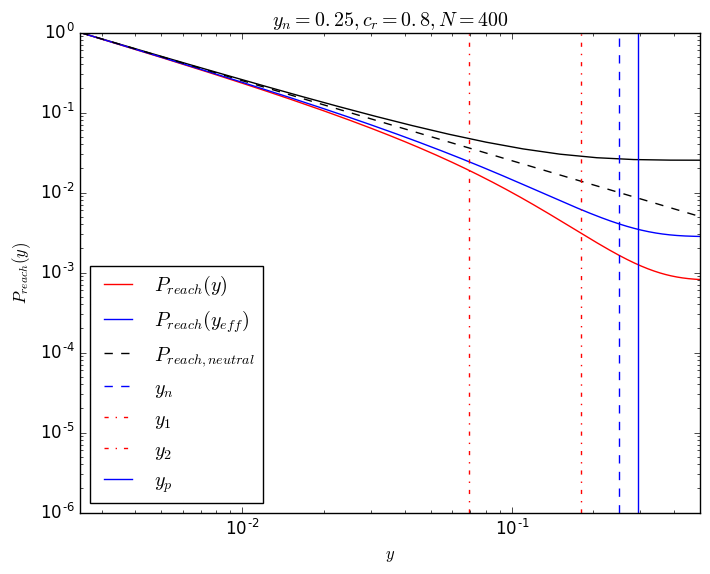

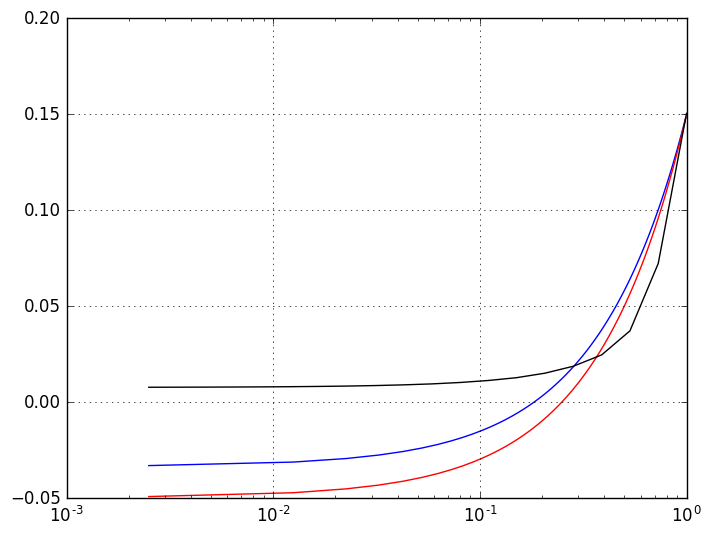

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3231ad890>

In [7]:
pygui(false)
figure(2)
loglog(xx,yy,"-k")
#loglog(xvals_regular12_g,pvals_regular12_g,"ob")
#loglog(xvals_two_level_g,pvals_two_level_g,"ok")


# #loglog(xvals_regular4_g,pvals_regular4_g,"og")
# #loglog(xvals_two_level_wm,pvals_two_level_wm,"^k")
# loglog(xvals_two_level_g1,pvals_two_level_g1,"^k")
# loglog(xvals_two_level_g2,pvals_two_level_g2,"sk")

plot_schematics(N,n_n,alpha,beta,im,imk,k)
#plot_schematics(20,n_n,alpha,beta,im,imk,10)
figure(2)
ylim([1e-6,1])
figure(3)
plot(xx,s_eff_two_level(xx),"-k")

In [66]:
figure(2)
loglog(xx,yy)

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3177d0450>

In [11]:
#t = runs[1].graph_information.data.t
println("Data P_fixed: $(num_fixed/num_trials)")

println("N: $N")
println("n_n: $(n_n)")
println("r: $(t.r), l: $(t.l)")
println("alpha: $alpha, beta: $beta")

LoadError: LoadError: UndefVarError: num_fixed not defined
while loading In[11], in expression starting on line 2

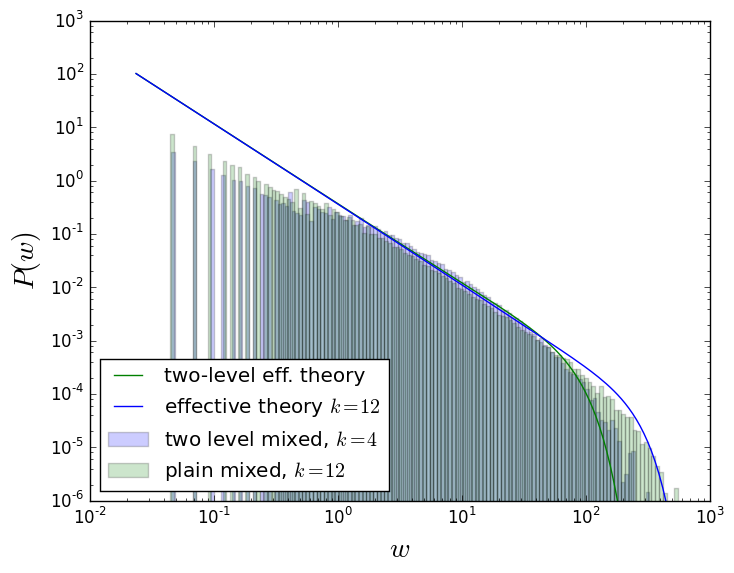

3954


In [22]:
s_eff_fn(x) = get_s_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
#plot_w(sizes,N,alpha,beta,s_eff_fn,"two level graph")
plot_w(sizes_two_level,N,alpha,beta,s_eff_fn, "two level mixed")
plot_w(sizes_well_mixed,N,alpha,beta,t.l + t.r, "plain mixed")

In [86]:
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)

(Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0))

plot_two_level_schematic (generic function with 1 method)

In [104]:
@time P_reach(s,splus,N,1/N,xx)
@time P_reach_fast(s,splus,N,1/N,xx)

  0.411884 seconds (285.47 k allocations: 13.399 MB, 85.95% gc time)
  2.352493 seconds (9.41 M allocations: 446.035 MB, 41.74% gc time)


20-element Array{Any,1}:
 11.2804     
  6.65106    
  3.98405    
  2.40589    
  1.45725    
  0.88165    
  0.530472   
  0.315588   
  0.184018   
  0.103669   
  0.0550559  
  0.0263872  
  0.0105464  
  0.00305028 
  0.000505222
  3.50022e-5 
  7.59093e-7 
  5.32934e-9 
  3.43621e-11
  2.21476e-35

In [16]:
pp = P_reach(s,splus,N,1/N,xx)
#quadgk(splus,0.0001,0.11)
#using IM
#IM.P_fix(im,N,1/N)

20-element Array{Any,1}:
 18.1498  
 10.8476  
  6.64194 
  4.15533 
  2.66382 
  1.76401 
  1.22328 
  0.905319
  0.729693
  0.646866
  0.61959 
  0.615173
  0.614963
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962

In [9]:
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);


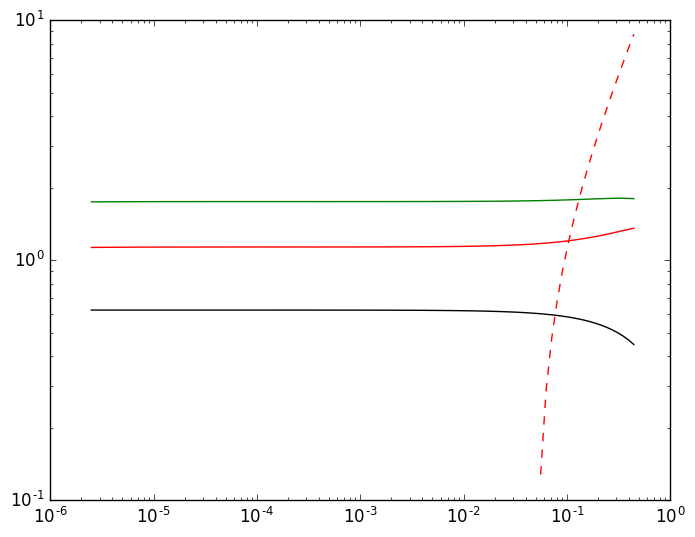

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3134a7ed0>

In [14]:
w_range = collect(0.01:0.01:100)
#yy = collect(0.01:0.01:1)
w_range = logspace(-6,4.5,100)
y_eff = sqrt(w_range)./N
s_eff = get_s_effective_two_level_interp(y_eff,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
s_birth_eff = get_s_birth_effective_two_level_interp(y_eff,alpha,y_susc_interp,y_sq_susc_interp)
s_death_eff = get_s_death_effective_two_level_interp(y_eff,beta,y_inf_interp)
loglog(y_eff,s_eff,"r")
loglog(y_eff,s_birth_eff,"g")
loglog(y_eff,s_death_eff,"k")
loglog(y_eff,s(y_eff,alpha,beta),"--r")
#xlim(0,0.01)
#plot(yy,y_sq_inf_interp(yy))
#y_inf_interp[sqrt(w_range)./N]

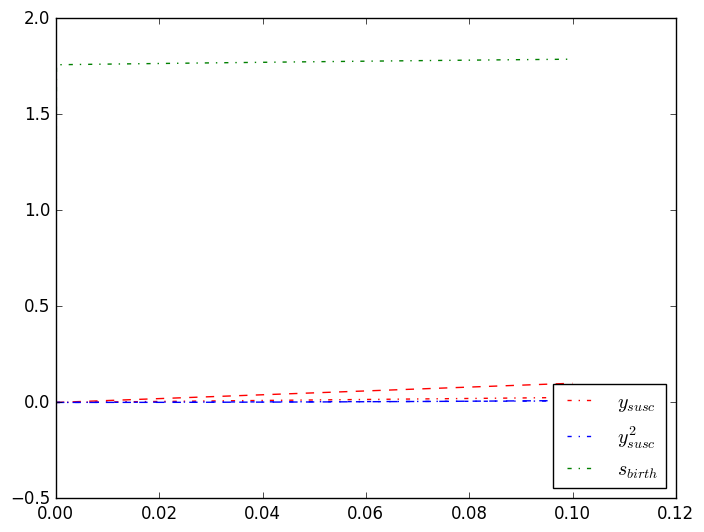

PyObject <matplotlib.legend.Legend object at 0x3142aea90>

In [15]:
using Dierckx
yy = 0:0.0001:0.1

# plot(yy,evaluate(y_inf_interp,yy),"r",label=L"y_{inf}")
# plot(yy,yy,"--r")

# plot(yy,evaluate(y_sq_inf_interp,yy),"b",label=L"y_{inf}^{2}")
# plot(yy,yy.^2,"--b")

plot(yy,evaluate(y_susc_interp,yy),"-.r",label=L"y_{susc}")
plot(yy,yy,"--r")

plot(yy,evaluate(y_sq_susc_interp,yy),"-.b",label=L"y_{susc}^2")
plot(yy,yy.^2,"--b")

 plot(yy,
 get_s_birth_effective_two_level_interp(collect(yy),alpha,y_susc_interp,y_sq_susc_interp),
 "-.g",label=L"s_{birth}")

#plot(yy,(1 - yy)./yy,"-k")
legend(loc="lower right")

#xlim([0,1])
#ylim([0,1])

In [ ]:
tolerance = 0.005
y_desired = 0.12



accum = get_mean_distribution_from_states(two_level_states,y_desired,tolerance)
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))



In [ ]:
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))


In [ ]:
#ion()
figure()

subplot(211)
title(latexstring("\$ \\bar{y} = $(y_desired)\$"))

semilogy(accum,label="graph simulation")
semilogy(accum_stationary,label="MCMC stationary distribution")
#xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()

subplot(212)
plot(accum,label="graph simulation")
plot(accum_stationary,label="MCMC stationary distribution")
xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()
savefig("../figures/mcmc_stationary_to_graph_comparison_y_$(y_desired).png")

In [ ]:
plot_schematics(N,alpha,beta,k,true)

In [ ]:
N = 1000
n_n = 400
c_r = 0.4
alpha,beta = get_alpha_beta(N,c_r,n_n)
plot_schematics(N,alpha,beta,k,true)
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
IM.P_fix(im,N,1/N)

In [28]:
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,t.r + t.l) , x -> 1 + beta);
IM.P_fix(im,N,1/N)
# xx = 0:0.01:1
# plot(xx,get_s_eff(xx,alpha,beta,N-1))

0.02272815639230584

# why are there zero fixed for the graph case?

In [10]:
#using Grid
interpolation_function_path = "../data/interpolations.jld"
#y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
#save(interpolation_function_path,"y_inf_interp",y_inf_interp,"y_sq_inf_interp",y_sq_inf_interp,"y_susc_interp",y_susc_interp,"y_sq_susc_interp",y_sq_susc_interp)
interpolation_functions = load(interpolation_function_path)
y_inf_interp = interpolation_functions["y_inf_interp"]
y_sq_inf_interp = interpolation_functions["y_sq_inf_interp"]
y_susc_interp = interpolation_functions["y_susc_interp"]
y_sq_susc_interp = interpolation_functions["y_sq_susc_interp"]



Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0)

In [195]:
# k = 4
# #y_n = 0.1
# c_r = 0.18
# N = 400#100000#400
# n_n = 10#10#y_n*N
# beta = 4.0/(c_r*n_n)
# alpha = (N*beta)/n_n
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
println("N: $(N), n_n: $(n_n), l: $(t.l), t.r: $(t.r), ")
dt = get_dt_two_level(alpha,beta)
run_epidemic_fn = () -> run_epidemic_well_mixed_two_level(dt,N,y_susc_interp,y_sq_susc_interp,y_inf_interp,y_sq_inf_interp,alpha,beta,1.0)


N: 1000, n_n: 150, l: 10, t.r: 2, 


(anonymous function)

In [196]:
@time runs_two_level = run_epidemics(10000,run_epidemic_fn);

xvals_two_level_wm,pvals_two_level_wm = get_p_reach(runs_two_level)
xvals_two_level_wm /= N;

LoadError: LoadError: InterruptException:
while loading In[196], in expression starting on line 155

In [28]:
im_effective = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,t.l + t.r) , x -> 1 + beta);
runs_well_mixed = run_epidemics(10000, () -> run_epidemic_well_mixed(N,im_effective,1.0));

im_effective4 = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
runs_well_mixed4 = run_epidemics(10000, () -> run_epidemic_well_mixed(N,im_effective4,1.0));



In [38]:
k

4

In [47]:
pp = P_reach(s,splus,N,1/N,xx);

0.6476
0.

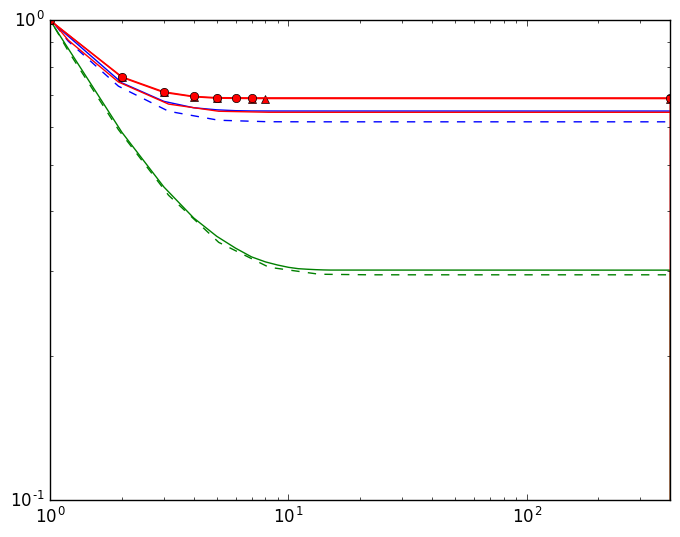

3019


(0.1,1.0)

In [43]:
sizes_two_level = get_sizes(runs_two_level)
num_fixed_two_level = get_num_fixed(runs_two_level)
xvals_two_level,pvals_two_level = get_p_reach(runs_two_level)
figure(3)
loglog(xvals_two_level,pvals_two_level,"b")
println(num_fixed_two_level/length(runs_two_level))

sizes_well_mixed = get_sizes(runs_well_mixed)
num_fixed_well_mixed = get_num_fixed(runs_well_mixed)
xvals_well_mixed,pvals_well_mixed = get_p_reach(runs_well_mixed)
xvals_well_mixed4,pvals_well_mixed4 = get_p_reach(runs_well_mixed4)
figure(3)
loglog(xvals_well_mixed,pvals_well_mixed,"g")
loglog(xvals_well_mixed4,pvals_well_mixed4,"-^r")
println(num_fixed_well_mixed/length(runs_well_mixed))


loglog(N*xx,pp,"--b")
loglog(N*xx,P_reach(im_effective,N,1/N,xx),"--g")
loglog(N*xx,P_reach(im_effective4,N,1/N,xx),"r")


#loglog(N*xvals_mixed_g,pvals_mixed_g,"-k")
loglog(N*xvals_regular4_g,pvals_regular4_g,"-or")
#loglog(N*xvals_two_level_g,pvals_two_level_g,"-k")
xlim([1,N])
ylim([0.1,1])

## todo why doesn't the process converge?

## vary the fixation threshold and measure accuracy

## Ideas for future work:

    ### - use clustering and second order properties ($y$, $q_{0,0}$, $q_{1,0}$
    ### - discretize a vector ($a_j$ is the number of subgraphs with a fraction $j/jmax$ of infecteds). Calculate the average incoming edges using variations in $k$.

In [ ]:
## Lior Pachter